# IMPORT LIBRARY

In [120]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns 


# MODEL

## Layer

In [121]:
class Layer:
    def __init__(self, n_neurons, init='zero', activation='linear', init_params=None, weights=None, biases=None):
        """
        Initialize a neural network layer
        
        Parameters:
        -----------
        n_neurons : int
            Number of neurons in the layer
        init : str, optional (default='zero')
            Initialization method. Options:
            - 'zero': Zero initialization
            - 'uniform': Uniform random distribution
            - 'normal': Normal (Gaussian) random distribution
        activation : str, optional (default='linear')
            Activation function to use
        init_params : dict, optional
            Additional parameters for initialization:
            - For 'uniform': 
                * 'lower': lower bound (default: -1)
                * 'upper': upper bound (default: 1)
                * 'seed': random seed (optional)
            - For 'normal':
                * 'mean': mean of distribution (default: 0)
                * 'variance': variance of distribution (default: 1)
                * 'seed': random seed (optional)
        """
        self.n_neurons = n_neurons
        self.init = init
        self.activation = activation
        self.init_params = init_params or {}
        
        if self.init == 'uniform':
            self.init_params.setdefault('lower', -1)
            self.init_params.setdefault('upper', 1)
        elif self.init == 'normal':
            self.init_params.setdefault('mean', 0)
            self.init_params.setdefault('variance', 1)
        
        self.weights = weights
        self.biases = biases
    
    def initialize(self, input_dim):
        if 'seed' in self.init_params:
            np.random.seed(self.init_params['seed'])

        self.biases = np.zeros((1, self.n_neurons))
        if self.init == 'zero':
            self.weights = np.zeros((input_dim, self.n_neurons))
        
        elif self.init == 'uniform':
            lower = self.init_params['lower']
            upper = self.init_params['upper']
            self.weights = np.random.uniform(low=lower, high=upper, size=(input_dim, self.n_neurons))
        
        elif self.init == 'normal':
            mean = self.init_params['mean']
            variance = self.init_params['variance']
            self.weights = np.random.normal(loc=mean, scale=np.sqrt(variance), size=(input_dim, self.n_neurons))
        
        elif self.init == 'xavier_uniform':
            limit = np.sqrt(6 / (input_dim + self.n_neurons))
            self.weights = np.random.uniform(-limit, limit, (input_dim, self.n_neurons))
        
        elif self.init == 'xavier_normal':
            std = np.sqrt(2 / (input_dim + self.n_neurons))
            self.weights = np.random.normal(0, std, (input_dim, self.n_neurons))
        
        elif self.init == 'he_normal':
            std = np.sqrt(2 / input_dim)
            self.weights = np.random.normal(0, std, (input_dim, self.n_neurons))
        
        elif self.init == 'he_uniform':
            limit = np.sqrt(6 / input_dim)
            self.weights = np.random.uniform(-limit, limit, (input_dim, self.n_neurons))
        
        else:
            raise ValueError(
                f"Unknown initialization type: {self.init}\n"
                "Available types: zero, uniform, normal, xavier_uniform, xavier_normal, he_normal, he_uniform"
            )
        
        return self
        
    def activate(self, x):
        if self.activation == 'linear':
            return x
        elif self.activation == 'relu':
            return np.maximum(0, x)
        elif self.activation == 'leaky_relu':
            return np.where(x > 0, x, 0.01 * x)
        elif self.activation == 'elu':
            return np.where(x > 0, x, 0.01 * (np.exp(x) - 1))
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation == 'tanh':
            return np.tanh(x)
        elif self.activation == 'softmax':
            exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
            return exp_x / np.sum(exp_x, axis=1, keepdims=True)
        else:
            raise ValueError(
                f"Unknown activation function: {self.activation}\n"
                "/n Activation function available: linear, relu,sigmoid, tanh, softmax, elu, leaky_relu"
            )
    
    def activation_derivative(self, x):
        if self.activation == 'linear':
            return np.ones_like(x)
        elif self.activation == 'relu':
            return (x > 0).astype(float)
        elif self.activation == 'leaky_relu':
            return np.where(x > 0, 1, 0.01)
        elif self.activation == 'elu':
            alpha = 0.01
            return np.where(x > 0, 1, alpha * np.exp(x))
        elif self.activation == 'sigmoid':
            s = self.activate(x)
            return s * (1 - s)
        elif self.activation == 'tanh':
            t = np.tanh(x)
            return 1 - t**2
        elif self.activation == 'softmax':
            return 1
        else:
            raise ValueError(
                f"Unknown activation function: {self.activation}/n"
                "Activation function available: linear, relu,sigmoid, tanh, softmax, elu, leaky_relu"
            )


## Tambahan

In [122]:
'''
Note:
- if y_true.ndim == 1: y_true = y_true.reshape(-1, 1) -> Kalo array 1D ubah jadi array 2D
- if y_true.shape != y_pred.shape: y_true = np.eye(y_pred.shape[1])[y_true.flatten()] -> handle kalo y_true contain class label bukan one hot 
'''

def mse(y_true, y_pred):
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)
    if y_true.shape != y_pred.shape:
        y_true = np.eye(y_pred.shape[1])[y_true.flatten()]
    return np.mean((y_true - y_pred) ** 2)

def mse_derivative(y_true, y_pred):
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)
    if y_true.shape != y_pred.shape:
        y_true = np.eye(y_pred.shape[1])[y_true.flatten()]
    return 2 * (y_pred - y_true) / y_true.shape[0] 

def bce(y_true, y_pred):
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)
    if y_true.shape != y_pred.shape:
        y_true = np.eye(y_pred.shape[1])[y_true.flatten()]
    
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))


def bce_derivative(y_true, y_pred):
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)
    if y_true.shape != y_pred.shape:
        y_true = np.eye(y_pred.shape[1])[y_true.flatten()]
    
    epsilon = 1e-7  
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return (y_pred - y_true) / (y_pred * (1 - y_pred) + epsilon)

def cce(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    if y_true.ndim == 1 or (y_true.ndim == 2 and y_true.shape[1] == 1):
        y_true = np.eye(y_pred.shape[1])[y_true.flatten()]
    
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

def cce_derivative(y_true, y_pred):
    if y_true.ndim == 1 or (y_true.ndim == 2 and y_true.shape[1] == 1):
        y_true = np.eye(y_pred.shape[1])[y_true.flatten()]
    
    return y_pred - y_true

## FFNN

In [123]:
class FFNN:
    def __init__(self, loss='mse', batch_size=32, learning_rate=0.01, epochs=100, verbose=1):
        self.layers = []
        self.learning_rate = learning_rate
        self.loss = loss
        self.batch_size = batch_size
        self.epochs = epochs
        self.verbose = verbose
        self.train_losses = []
        self.val_losses = []
        
        if loss == 'mse':
            self.loss_func = mse
            self.loss_derivative = mse_derivative
        elif loss == 'bce':
            self.loss_func = bce
            self.loss_derivative = bce_derivative
        elif loss == 'cce':
            self.loss_func = cce
            self.loss_derivative = cce_derivative
        else:
            raise ValueError(
                f"Unknown loss function: {loss}\n"
                "Loss function available: mse, bce, cce"
            )
    
    def build_layers(self, *layer_args):
        self.layers = list(layer_args)
    
    def _initialize_network(self, input_dim):
        prev_dim = input_dim
        for layer in self.layers:
            layer.initialize(prev_dim)
            prev_dim = layer.n_neurons
    
    def forward(self, X):
        if X.ndim == 1:
            X = X.reshape(1, -1)
        
        activations = [X]
        zs = []
        
        for layer in self.layers:
            z = activations[-1] @ layer.weights + layer.biases # @ itu dot product
            a = layer.activate(z)
            zs.append(z)
            activations.append(a)
            
        return zs, activations
    
    def backward(self, X, y, zs, activations):
        m = X.shape[0]
        y_pred = activations[-1]
        
        delta = self.loss_derivative(y, y_pred)
        
        for i in reversed(range(len(self.layers))):
            z = zs[i]
            a_prev = activations[i]
            
            grad_w = (a_prev.T @ delta) / m
            grad_b = np.sum(delta, axis=0, keepdims=True) / m

            self.layers[i].weights -= self.learning_rate * grad_w
            self.layers[i].biases -= self.learning_rate * grad_b
            
            if i > 0:
                delta = (delta @ self.layers[i].weights.T) * self.layers[i - 1].activation_derivative(zs[i - 1])
    
    def fit(self, X, y, X_val=None, y_val=None):
        self._initialize_network(X.shape[1])
        
        # Kalo gaada val data -> trainnya displit 
        if X_val is None or y_val is None:
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        else:
            X_train, y_train = X, y
        
        if self.verbose == 0:
            for epoch in range(self.epochs):
                indices = np.arange(X.shape[0])
                np.random.shuffle(indices)
                
                for start in range(0, X.shape[0], self.batch_size):
                    end = start + self.batch_size
                    batch_indices = indices[start:end]
                    X_batch = X[batch_indices]
                    y_batch = y[batch_indices]
                    
                    zs, activations = self.forward(X_batch)
                    self.backward(X_batch, y_batch, zs, activations)
        
        elif self.verbose == 1:
            for epoch in range(self.epochs):
                epoch_progress = tqdm(total=X.shape[0], desc=f"Epoch {epoch+1}/{self.epochs}", unit='sample')
                
                indices = np.arange(X.shape[0])
                np.random.shuffle(indices)
                
                for start in range(0, X.shape[0], self.batch_size):
                    end = start + self.batch_size
                    batch_indices = indices[start:end]
                    X_batch = X[batch_indices]
                    y_batch = y[batch_indices]
                    
                    zs, activations = self.forward(X_batch)
                    self.backward(X_batch, y_batch, zs, activations)

                    epoch_progress.update(len(X_batch))
                
                epoch_progress.close()
                
                y_train_pred = self.forward(X)[1][-1]
                train_loss = self.loss_func(y, y_train_pred)
                
                y_val_pred = self.forward(X_val)[1][-1]
                val_loss = self.loss_func(y_val, y_val_pred)

                self.train_losses.append(train_loss)
                self.val_losses.append(val_loss)
                
                print(f"Epoch {epoch+1}/{self.epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        else:
            raise ValueError(
                f"Invalid verbose value: {self.verbose}\n"
                "Verbose options: 0 (no output), 1 (progress bar)"
            )
    
    def predict(self, X):
        _, activations = self.forward(X)
        if self.loss == 'cce':  
            return np.argmax(activations[-1], axis=1)
        return activations[-1]
    
    def save(self, filename):
        model_state = {
            'layers': self.layers,
            'learning_rate': self.learning_rate,
            'loss': self.loss,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'verbose': self.verbose
        }
        with open(filename, 'wb') as f:
            pickle.dump(model_state, f)

        print(f"Model saved to {filename}")
    
    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            model_state = pickle.load(f)
        
        model = cls(
            loss=model_state['loss'],
            batch_size=model_state['batch_size'],
            learning_rate=model_state['learning_rate'],
            epochs=model_state['epochs'],
            verbose=model_state['verbose']
        )
        
        model.layers = model_state['layers']
        print(f"Model loaded from {filename}")
        return model

    # TODO: imporove this
    def visualize_architecture(self, output_file='neural_network.png', figsize=(12, 8)):
        G = nx.DiGraph()
        layers = []
        
        if len(self.layers) > 0:
            input_dim = self.layers[0].weights.shape[0]
            input_layer = [f'Input {i}' for i in range(input_dim)]
            layers.append(input_layer)
        
        for layer_idx, layer in enumerate(self.layers):
            layer_nodes = [f'Layer {layer_idx} Neuron {i}' for i in range(layer.n_neurons)]
            layers.append(layer_nodes)
        
        plt.figure(figsize=figsize)
        
        pos = {}
        max_nodes_in_layer = max(len(layer) for layer in layers)
        
        for layer_idx, layer_nodes in enumerate(layers):
            y_spacing = 1 / (len(layer_nodes) + 1)
            for node_idx, node in enumerate(layer_nodes):
                y = 1 - (node_idx + 1) * y_spacing
                x = layer_idx / (len(layers) - 1)
                pos[node] = (x, y)
                G.add_node(node)
        
        # Add edges between layers
        for layer_idx in range(len(layers) - 1):
            for prev_node in layers[layer_idx]:
                for curr_node in layers[layer_idx + 1]:
                    prev_idx = layers[layer_idx].index(prev_node)
                    curr_idx = layers[layer_idx + 1].index(curr_node)

                    if layer_idx < len(self.layers):
                        weight = self.layers[layer_idx].weights[prev_idx, curr_idx]
                        bias = self.layers[layer_idx].biases[0, curr_idx]
                        G.add_edge(prev_node, curr_node, weight=weight, bias=bias)
        
        plt.title("Neural Network Architecture")
        
        nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500, alpha=0.8)
        nx.draw_networkx_labels(G, pos, font_size=8, font_weight="bold")
        
        edges = G.edges()
        weights = [G[u][v]['weight'] for u, v in edges]
        
        min_weight, max_weight = min(weights), max(weights)
        normalized_weights = [(w - min_weight) / (max_weight - min_weight) for w in weights]
        
        nx.draw_networkx_edges(
            G, pos, 
            edge_color=[plt.cm.RdYlGn(w) for w in normalized_weights],
            width=[2 + 5 * w for w in normalized_weights],
            alpha=0.7,
            arrows=True
        )
        
        edge_labels = {(u, v): f'w: {G[u][v]["weight"]:.2f}\nb: {G[u][v]["bias"]:.2f}' 
                       for (u, v) in G.edges()}
        nx.draw_networkx_edge_labels(
            G, pos, 
            edge_labels=edge_labels, 
            font_color='red', 
            font_size=6
        )
        
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        
        return plt.gcf()
    
    # TODO: Ini titlenya masi ke override2, nanti aku benerin lagi 
    def plot_weight_distribution(self, layers_to_plot=None, figsize=(12, 4)):
        if layers_to_plot is None:
            layers_to_plot = range(len(self.layers))

        fig, axes = plt.subplots(1, len(layers_to_plot), figsize=figsize)

        if len(layers_to_plot) == 1:
            axes = [axes]

        for i, layer_idx in enumerate(layers_to_plot):
            layer = self.layers[layer_idx]
            weights = layer.weights.flatten()

            sns.histplot(weights, kde=True, ax=axes[i])
            axes[i].set_title(f'Layer {layer_idx} Weight Distribution')
            axes[i].set_xlabel('Weight Values')
            axes[i].set_ylabel('Frequency')
        
        plt.tight_layout()
        return fig
    
    # TODO: Ini titlenya masi ke override2, nanti aku benerin lagi 
    def plot_gradient_distribution(self, X, y, layers_to_plot=None, figsize=(12, 4)):
        zs, activations = self.forward(X)
        self.backward(X, y, zs, activations)
        
        if layers_to_plot is None:
            layers_to_plot = range(len(self.layers))
        
        fig, axes = plt.subplots(1, len(layers_to_plot), figsize=figsize)

        if len(layers_to_plot) == 1:
            axes = [axes]
        
        for i, layer_idx in enumerate(layers_to_plot):
            layer = self.layers[layer_idx]
            
            delta = self.loss_derivative(y, activations[-1])
            grad_w = np.zeros_like(layer.weights)
            
            sns.histplot(grad_w.flatten(), kde=True, ax=axes[i])
            axes[i].set_title(f'Layer {layer_idx} Gradient Distribution')
            axes[i].set_xlabel('Gradient Values')
            axes[i].set_ylabel('Frequency')
        
        plt.tight_layout()
        return fig
    
    # TODO: Ini titlenya masi ke override2, nanti aku benerin lagi 
    def compute_gradient_statistics(self, X, y):
        zs, activations = self.forward(X)
        self.backward(X, y, zs, activations)
        
        gradient_stats = {}
        
        for layer_idx, layer in enumerate(self.layers):
            delta = self.loss_derivative(y, activations[-1])
            grad_w = np.zeros_like(layer.weights)
            
            gradient_stats[layer_idx] = {
                'mean': np.mean(grad_w),
                'std': np.std(grad_w),
                'min': np.min(grad_w),
                'max': np.max(grad_w)
            }
        
        return gradient_stats

    def plot_training_loss(self):
        if not self.train_losses or not self.val_losses:
            print("Loss history is empty. Train the model first.")
            return
        
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.title("Training and Validation Loss over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


# LOAD DATA

In [124]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = y.astype(np.uint8)

In [125]:
X.shape

(70000, 784)

In [126]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, train_size=65000, test_size=5000, stratify=y, random_state=42)

In [127]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, train_size=0.8, stratify=y_train_full, random_state=42)

In [128]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# MODEL TESTING

## Test Class Layer and FFNN

In [129]:
model_ffnn = FFNN(
    loss='mse',
    batch_size=200,
    learning_rate=0.01,
    epochs=20,
    verbose=1
)

In [130]:
model_ffnn.build_layers(
    Layer(n_neurons=2, init='zero', activation='linear'),
    Layer(n_neurons=2, init='uniform', activation='relu', init_params={'lower': -0.5, 'upper': 0.5}),
    Layer(n_neurons=2, init='normal', activation='tanh', init_params={'mean': 0, 'variance': 0.01}),
    Layer(n_neurons=2, init='xavier_normal', activation='softmax'),
    Layer(n_neurons=2, init='xavier_uniform', activation='leaky_relu'),
    Layer(n_neurons=2, init='he_normal', activation='elu'),
    Layer(n_neurons=10, init='he_uniform', activation='sigmoid')
)

In [131]:
model_ffnn.fit(X_train, y_train)

Epoch 1/20: 100%|██████████| 52000/52000 [00:00<00:00, 128306.40sample/s]


Epoch 1/20 - Train Loss: 0.2479, Val Loss: 0.2479


Epoch 2/20: 100%|██████████| 52000/52000 [00:00<00:00, 161843.46sample/s]


Epoch 2/20 - Train Loss: 0.2459, Val Loss: 0.2459


Epoch 3/20: 100%|██████████| 52000/52000 [00:01<00:00, 43829.95sample/s]


Epoch 3/20 - Train Loss: 0.2439, Val Loss: 0.2439


Epoch 4/20: 100%|██████████| 52000/52000 [00:00<00:00, 53121.51sample/s]


Epoch 4/20 - Train Loss: 0.2419, Val Loss: 0.2419


Epoch 5/20: 100%|██████████| 52000/52000 [00:01<00:00, 43944.16sample/s]


Epoch 5/20 - Train Loss: 0.2399, Val Loss: 0.2399


Epoch 6/20: 100%|██████████| 52000/52000 [00:00<00:00, 96052.28sample/s] 


Epoch 6/20 - Train Loss: 0.2380, Val Loss: 0.2380


Epoch 7/20: 100%|██████████| 52000/52000 [00:00<00:00, 94535.14sample/s]


Epoch 7/20 - Train Loss: 0.2361, Val Loss: 0.2361


Epoch 8/20: 100%|██████████| 52000/52000 [00:00<00:00, 112285.79sample/s]


Epoch 8/20 - Train Loss: 0.2342, Val Loss: 0.2342


Epoch 9/20: 100%|██████████| 52000/52000 [00:00<00:00, 79222.75sample/s]


Epoch 9/20 - Train Loss: 0.2323, Val Loss: 0.2323


Epoch 10/20: 100%|██████████| 52000/52000 [00:00<00:00, 82257.66sample/s]


Epoch 10/20 - Train Loss: 0.2305, Val Loss: 0.2305


Epoch 11/20: 100%|██████████| 52000/52000 [00:00<00:00, 117283.25sample/s]


Epoch 11/20 - Train Loss: 0.2287, Val Loss: 0.2287


Epoch 12/20: 100%|██████████| 52000/52000 [00:00<00:00, 102258.32sample/s]


Epoch 12/20 - Train Loss: 0.2269, Val Loss: 0.2269


Epoch 13/20: 100%|██████████| 52000/52000 [00:00<00:00, 126856.83sample/s]


Epoch 13/20 - Train Loss: 0.2251, Val Loss: 0.2251


Epoch 14/20: 100%|██████████| 52000/52000 [00:00<00:00, 83906.83sample/s]


Epoch 14/20 - Train Loss: 0.2234, Val Loss: 0.2234


Epoch 15/20: 100%|██████████| 52000/52000 [00:00<00:00, 73105.18sample/s]


Epoch 15/20 - Train Loss: 0.2217, Val Loss: 0.2217


Epoch 16/20: 100%|██████████| 52000/52000 [00:00<00:00, 75114.76sample/s]


Epoch 16/20 - Train Loss: 0.2200, Val Loss: 0.2200


Epoch 17/20: 100%|██████████| 52000/52000 [00:00<00:00, 83415.84sample/s]


Epoch 17/20 - Train Loss: 0.2183, Val Loss: 0.2183


Epoch 18/20: 100%|██████████| 52000/52000 [00:00<00:00, 66001.14sample/s]


Epoch 18/20 - Train Loss: 0.2167, Val Loss: 0.2167


Epoch 19/20: 100%|██████████| 52000/52000 [00:00<00:00, 74766.16sample/s]


Epoch 19/20 - Train Loss: 0.2151, Val Loss: 0.2151


Epoch 20/20: 100%|██████████| 52000/52000 [00:00<00:00, 109654.46sample/s]


Epoch 20/20 - Train Loss: 0.2135, Val Loss: 0.2135


In [132]:
y_pred = model_ffnn.predict(X_test)
for h in y_pred:
    max_index = np.argmax(h)
    print(max_index)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


## Test Load n Save

In [133]:
model_ffnn.save('model_ffnn.pkl')

Model saved to model_ffnn.pkl


In [134]:
loaded_model = FFNN.load('model_ffnn.pkl')

Model loaded from model_ffnn.pkl


In [135]:
y_pred = loaded_model.predict(X_test)
for h in y_pred:
    max_index = np.argmax(h)
    print(max_index)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [136]:
y_test

array([2, 9, 0, ..., 4, 7, 7], dtype=uint8)

## Test Visualisation

Epoch 38/100:  28%|██▊       | 14400/52000 [14:21<37:30, 16.71sample/s]   


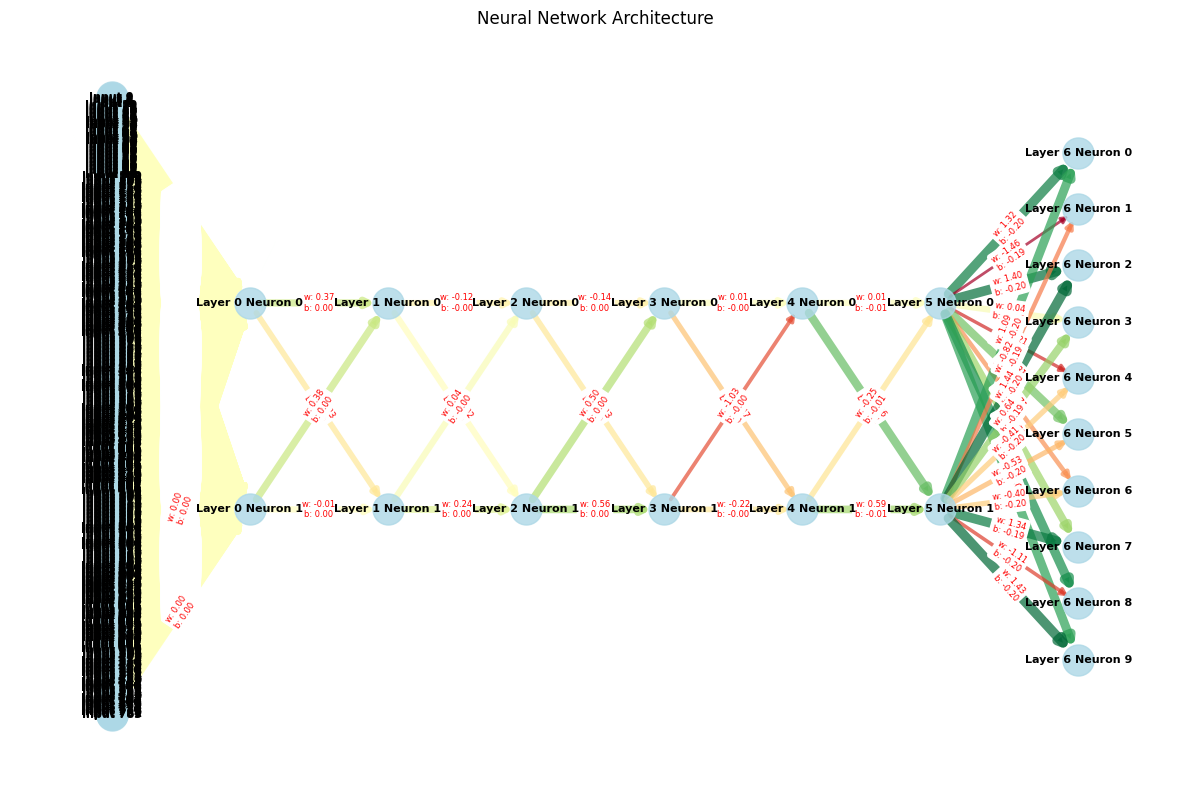

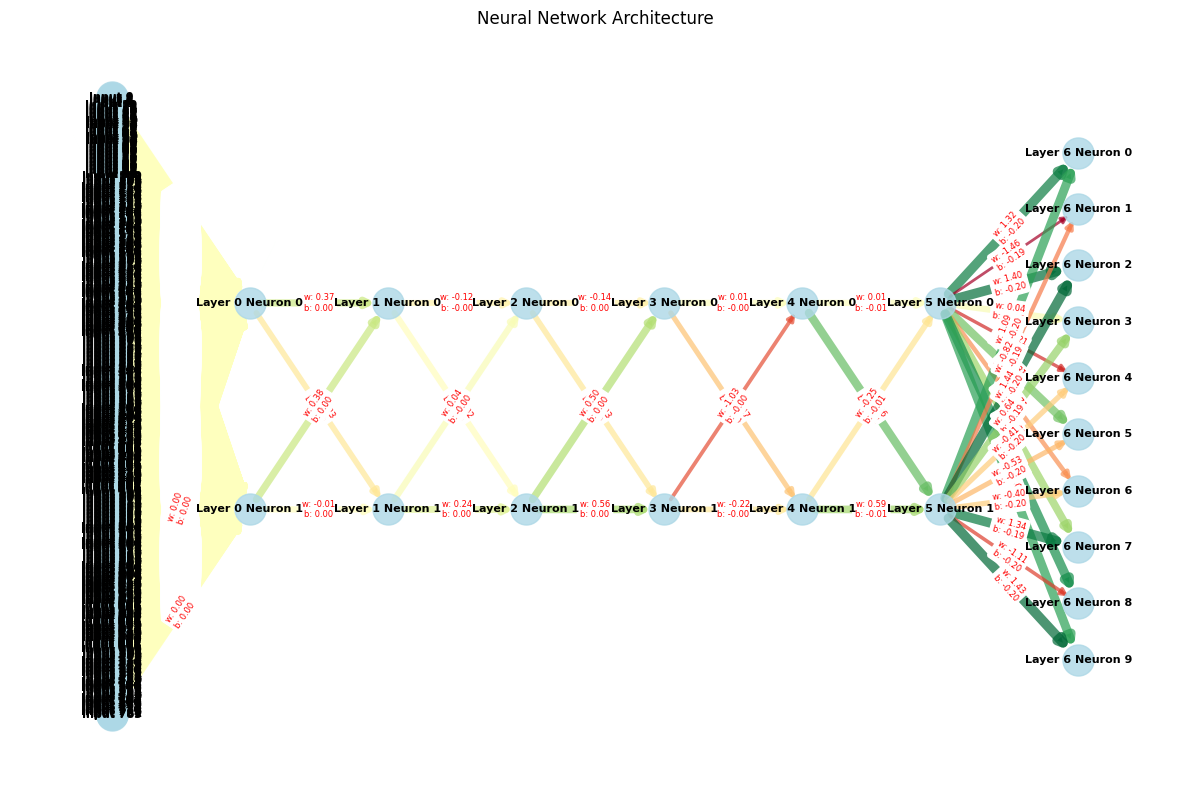

In [137]:
loaded_model.visualize_architecture()

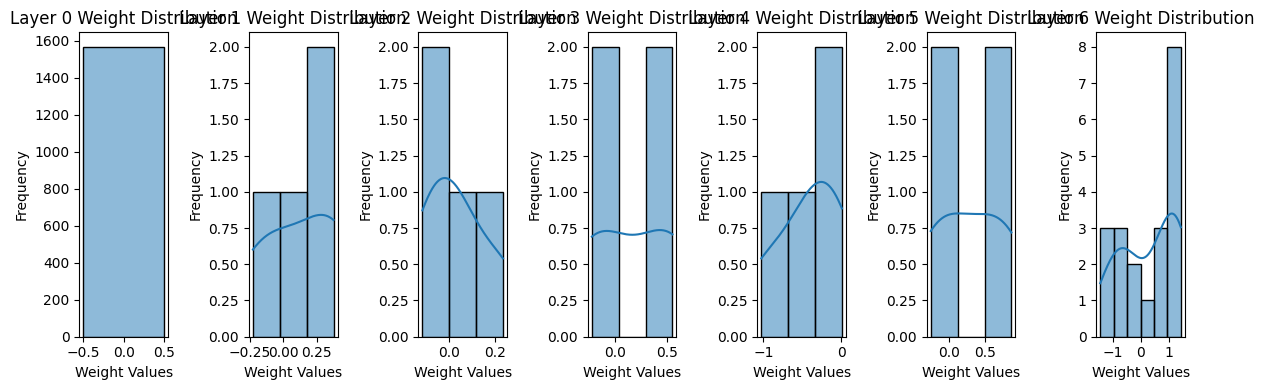

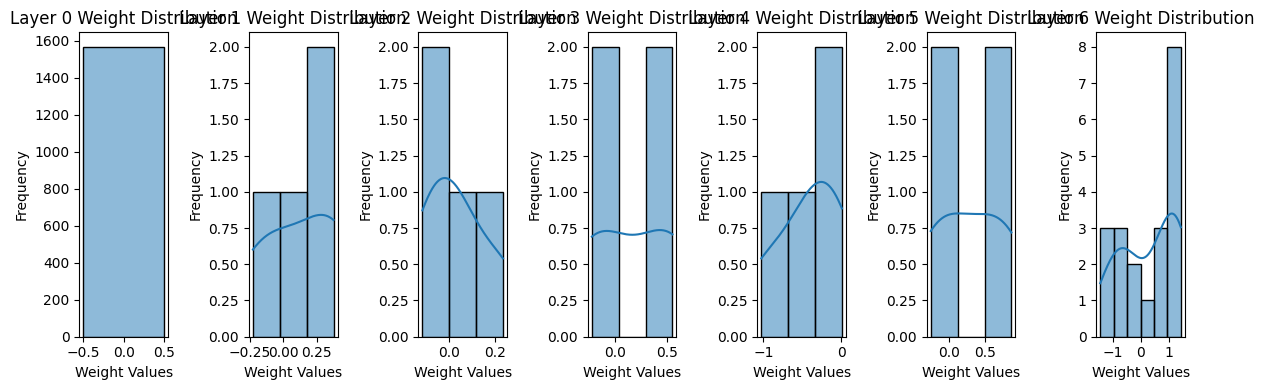

In [138]:
loaded_model.plot_weight_distribution()

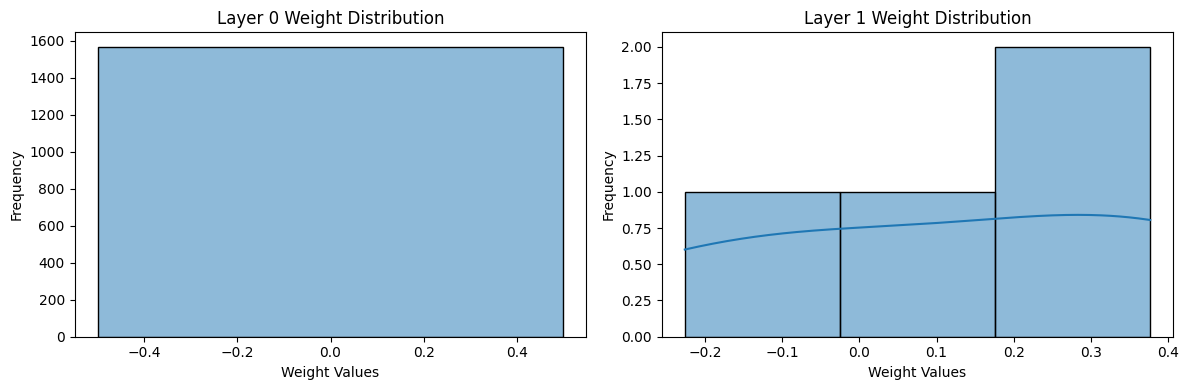

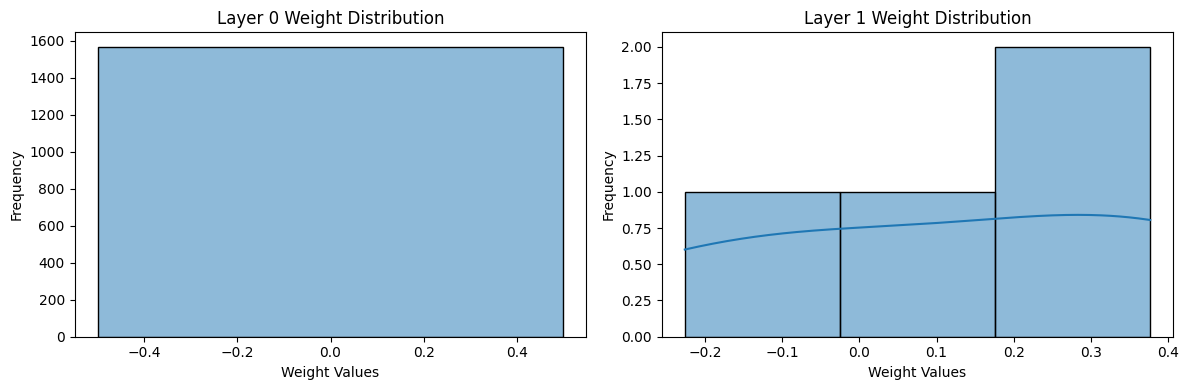

In [139]:
loaded_model.plot_weight_distribution(layers_to_plot=[0, 1])

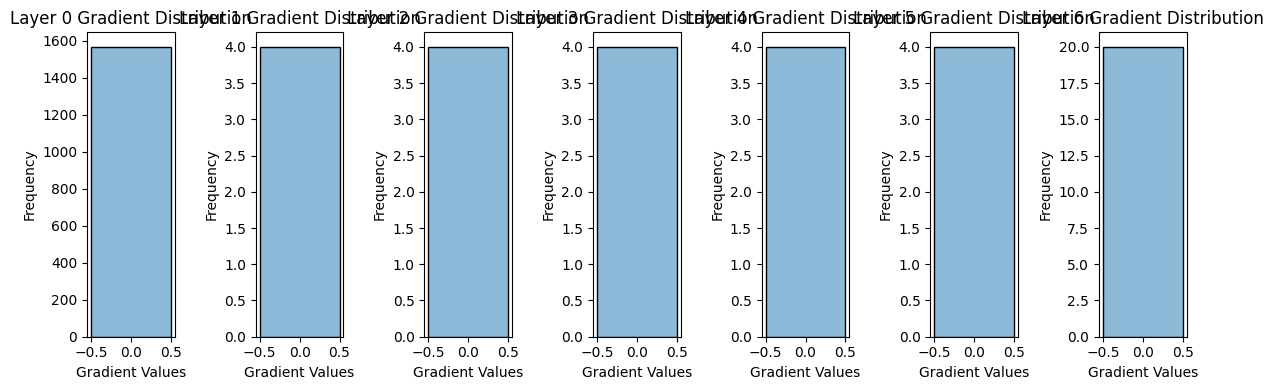

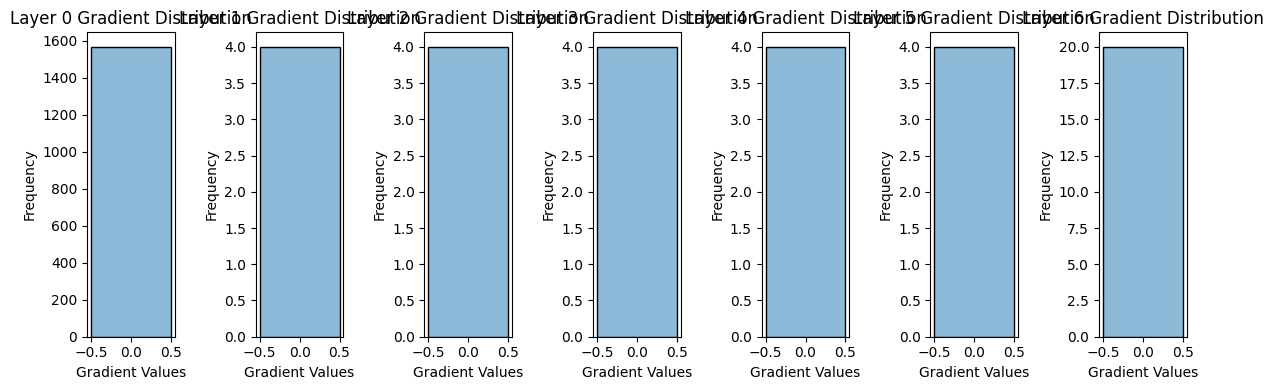

In [140]:
loaded_model.plot_gradient_distribution(X_train, y_train)

In [141]:
gradient_stats = loaded_model.compute_gradient_statistics(X_train, y_train)
for layer, stats in gradient_stats.items():
    print(f"Layer {layer} Gradient Statistics:")
    print(stats)

Layer 0 Gradient Statistics:
{'mean': 0.0, 'std': 0.0, 'min': 0.0, 'max': 0.0}
Layer 1 Gradient Statistics:
{'mean': 0.0, 'std': 0.0, 'min': 0.0, 'max': 0.0}
Layer 2 Gradient Statistics:
{'mean': 0.0, 'std': 0.0, 'min': 0.0, 'max': 0.0}
Layer 3 Gradient Statistics:
{'mean': 0.0, 'std': 0.0, 'min': 0.0, 'max': 0.0}
Layer 4 Gradient Statistics:
{'mean': 0.0, 'std': 0.0, 'min': 0.0, 'max': 0.0}
Layer 5 Gradient Statistics:
{'mean': 0.0, 'std': 0.0, 'min': 0.0, 'max': 0.0}
Layer 6 Gradient Statistics:
{'mean': 0.0, 'std': 0.0, 'min': 0.0, 'max': 0.0}


In [142]:
X_train.shape

(52000, 784)

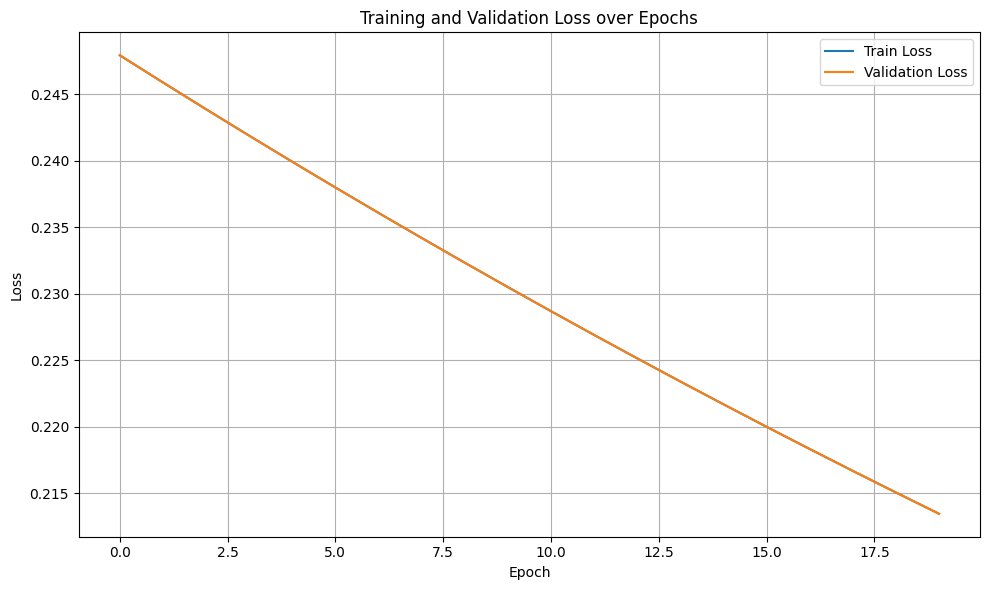

In [143]:
model_ffnn.plot_training_loss()